In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_full.csv")

metric = "Accuracy"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

method_order = [
    'ConstantPredictor', 'LogisticRegressor' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNClassifier', 'GPBoost_Accuracy', 'GPBoost_LogLoss', 'GPBoost_RMSE', 'GPBoost_CRPS'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LogisticRegressor': 'Logistic Regression',
    'TabPFNClassifier': 'TabPFN',
    'GPBoost_Accuracy': 'GPBoost',
    'GPBoost_LogLoss': 'GPBoost',
    'GPBoost_RMSE': 'GPBoost',
    'GPBoost_CRPS': 'GPBoost',
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

df = df[df["metric"] == "Accuracy"]
df = df[df["split_method"] == "random_split"]


=== RAW normalized_accuracy sample ===
     split_method  task_id                   model     value  baseline  \
0    random_split   361110       LogisticRegressor  0.731667  0.875000   
2    random_split   361110       ConstantPredictor  0.491667  0.875000   
17   random_split   361110        GPBoost_Accuracy  0.815000  0.875000   
24   random_split   361110              Engression  0.508333  0.875000   
27   random_split   361110                     MLP  0.815833  0.875000   
29   random_split   361110                  ResNet  0.821250  0.875000   
31   random_split   361110           FTTransformer  0.821667  0.875000   
56   random_split   361110        TabPFNClassifier  0.865000  0.875000   
64   random_split   361110  RandomForestClassifier  0.840417  0.875000   
66   random_split   361110          LGBMClassifier  0.875000  0.875000   
80   random_split   361111       LogisticRegressor  0.573587  0.649803   
82   random_split   361111       ConstantPredictor  0.487516  0.649803  

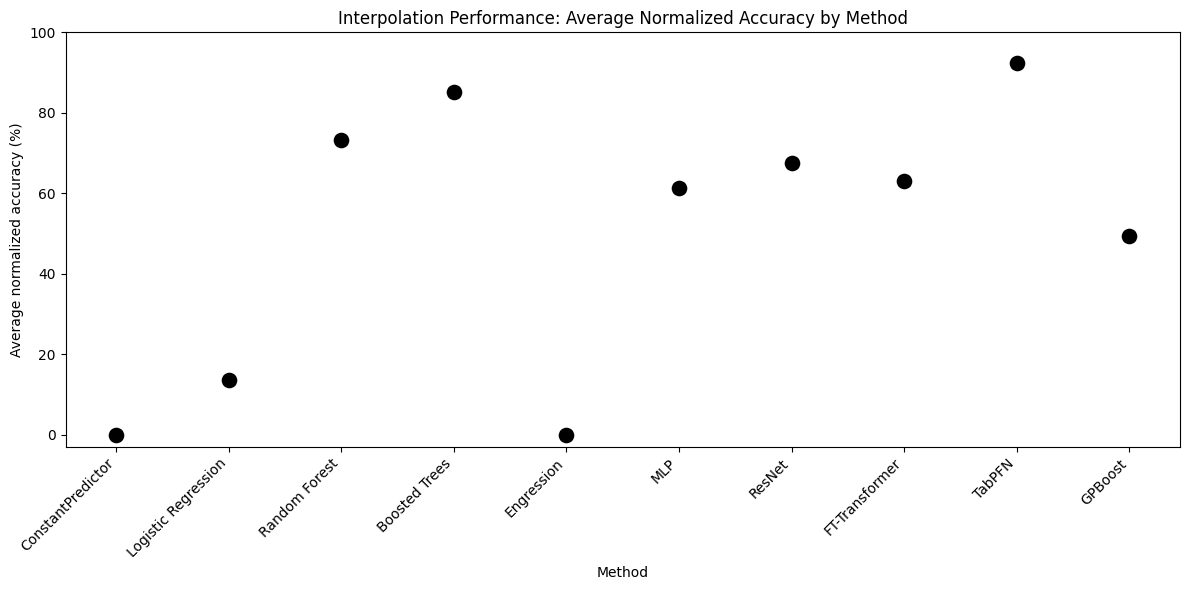

In [3]:
# helper to get the 3rd‐largest (or worst if <3)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nsmallest(3)
    return vals.max() if not vals.empty else np.nan

# 1) baseline (best = min error) per split & task
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("max")
)

# 2) mid (3rd‐largest error) per split & task
df["mid"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform(third_largest)
)

# 3) normalized accuracy: (mid – err)/(mid – best), clipped into [0,1]
df["normalized_accuracy"] = (
    (df["mid"] - df["value"])
    / (df["mid"] - df["baseline"])
).clip(0, 1)

print("\n=== RAW normalized_accuracy sample ===")
print(df[['split_method','task_id','model','value','baseline','mid','normalized_accuracy']].head(20))

print("\n=== per-model normalized_accuracy summary ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .agg(count='count', mean='mean', min='min', max='max')
    .sort_values('mean', ascending=False)
)

print("\n=== model appearance counts ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .count()
    .sort_values(ascending=False)
)

overall = (
    df
    .groupby('model')["normalized_accuracy"]
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100   # to percent

method_order = [
    'ConstantPredictor','LogisticRegressor',
    'RandomForestClassifier','RandomForestRegressor',
    'LGBMClassifier','LGBMRegressor','Engression',
    'MLP','ResNet','FTTransformer','TabPFNClassifier', 'GPBoost_Accuracy'
]
overall = (
    overall
    .set_index('model')
    .reindex(method_order)
    .reset_index()
)
rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':   'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_Accuracy':     'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=overall,
    x='Method',
    y='Mean',
    color='black',
    s=150
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average normalized accuracy (%)')
plt.xlabel('Method')
plt.title('Interpolation Performance: Average Normalized Accuracy by Method')
plt.ylim(-3, 100)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
fname = f"PICTURES/avg_normalized_acc_over_interpolation_{metric}.png"
plt.savefig(
    fname,
    bbox_inches='tight'
)
plt.show()


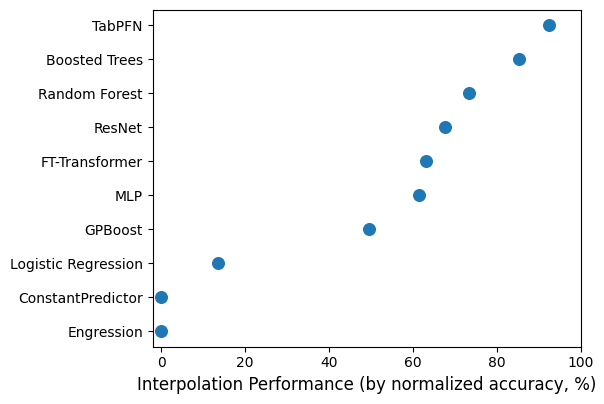

In [3]:
plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

# helper to get the 3rd‐largest (or worst if <3)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nsmallest(3)
    return vals.max() if not vals.empty else np.nan

# 1) baseline (best = min error) per split & task
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("max")
)

# 2) mid (3rd‐largest error) per split & task
df["mid"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform(third_largest)
)

# 3) normalized accuracy: (mid – err)/(mid – best), clipped into [0,1]
df["normalized_accuracy"] = (
    (df["mid"] - df["value"])
    / (df["mid"] - df["baseline"])
).clip(0, 1)



overall = (
    df
    .groupby('model')["normalized_accuracy"]
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100   # to percent

method_order = [
    'ConstantPredictor','LogisticRegressor',
    'RandomForestClassifier','RandomForestRegressor',
    'LGBMClassifier','LGBMRegressor','Engression',
    'MLP','ResNet','FTTransformer','TabPFNClassifier', 'GPBoost_Accuracy'
]
overall = (
    overall
    .set_index('model')
    .reindex(method_order)
    .reset_index()
)
rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':   'Logistic Regression',
    'TabPFNClassifier':     'TabPFN',
    'GPBoost_Accuracy':     'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

df["Method"] = df["model"].map(rename_map).fillna(df["model"])
stats = (df.groupby("Method")["normalized_accuracy"]
           .agg(mean="mean", std="std", count="count"))
stats["se"] = stats["std"] / np.sqrt(stats["count"]).replace(0, np.nan)
stats = (stats.sort_values("mean", ascending=False) * 100)  # percent

# 4) horizontal dot plot (readable labels, optional error bars)
ypos = np.arange(len(stats))
fig, ax = plt.subplots()
ax.scatter(stats["mean"].values, ypos, s=70)
#ax.errorbar(stats["mean"].values, ypos, xerr=None, fmt="o", ms=6, capsize=3, ls="none")
ax.set_yticks(ypos)
ax.set_yticklabels(stats.index)
ax.invert_yaxis()  # best at top
ax.set_xlabel("Interpolation Performance (by normalized accuracy, %)")
ax.set_ylabel("")
plt.xlim(-2, 100)
ax.grid(False)
plt.tight_layout()

# 5) vector export (crisp in LaTeX)
import os
os.makedirs("PICTURES", exist_ok=True)
plt.savefig("PICTURES/avg_normalized_acc_over_int_Accuracy.pdf", bbox_inches="tight")
plt.show()
plt.close()
